In [1]:
!pip3 install matplotlib



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Veri setini yükleme
data = pd.read_csv('0206_veriler.csv')

# Veri setini inceleme
print(data.head())
print(data.describe())

# Veri setini eğitim ve test kümelerine ayırma
X = data['Twitler']
y = data['Durum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                                             Twitler  Durum
0  a101 6 nisan firsatlari\n\nucuzkenaldim \n\nre...      1
1                                         trendyol        1
2                            alisverislerime devam        1
3  kargolarimi bana ulastirmak icin defalarca ara...      1
4              favorilerimin hepsini almak isterdim       1
            Durum
count  386.000000
mean     0.500000
std      0.500649
min      0.000000
25%      0.000000
50%      0.500000
75%      1.000000
max      1.000000


In [4]:
# DistilBERT tokenizer'ını oluşturma
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Veri setini tokenleme
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# PyTorch tensörlerine dönüştürme
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(list(y_train))
train_masks = torch.tensor(train_encodings['attention_mask'])
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(list(y_test))
test_masks = torch.tensor(test_encodings['attention_mask'])

In [5]:
# GPU kullanımı için tensörleri taşıma
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
train_masks = train_masks.to(device)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)
test_masks = test_masks.to(device)

In [6]:
# DistilBERT modelini yükleme
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [7]:
# Optimizer ve öğrenme oranını belirleme
optimizer = AdamW(model.parameters(), lr=1e-5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
import time

# Eğitim döngüsü
model.train()

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(10):
    optimizer.zero_grad()
    start_time = time.time()
    outputs = model(input_ids=train_inputs, attention_mask=train_masks, labels=train_labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time

    # Eğitim ve test verileri üzerinde loss değerlerini ve doğruluk değerlerini hesaplama
    train_loss_values.append(loss.item())
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        train_outputs = model(input_ids=train_inputs, attention_mask=train_masks)
        train_logits = train_outputs.logits
        train_predictions = torch.argmax(train_logits, dim=1)
        train_accuracy = accuracy_score(list(train_labels.cpu()), list(train_predictions.cpu()))
        train_accuracy_values.append(train_accuracy)

        test_outputs = model(input_ids=test_inputs, attention_mask=test_masks)
        test_logits = test_outputs.logits
        test_predictions = torch.argmax(test_logits, dim=1)
        test_accuracy = accuracy_score(list(test_labels.cpu()), list(test_predictions.cpu()))
        test_accuracy_values.append(test_accuracy)
        end_time = time.time()
        test_time = end_time - start_time

    model.train()

    # Epoch numarasını, loss değerini ve süreleri yazdırma
    print("Epoch:", epoch+1, "Loss:", loss.item(), "Train Time:", epoch_time, "Test Time:", test_time)

Epoch: 1 Loss: 0.6909036040306091 Train Time: 44.067429065704346 Test Time: 8.339303970336914
Epoch: 2 Loss: 0.6902660727500916 Train Time: 45.36633801460266 Test Time: 8.565883874893188
Epoch: 3 Loss: 0.6893720030784607 Train Time: 41.56595516204834 Test Time: 8.726716041564941
Epoch: 4 Loss: 0.6828367710113525 Train Time: 41.07702589035034 Test Time: 8.777689933776855
Epoch: 5 Loss: 0.6812519431114197 Train Time: 42.09895992279053 Test Time: 8.954124927520752
Epoch: 6 Loss: 0.6816962361335754 Train Time: 42.77246809005737 Test Time: 9.06107497215271
Epoch: 7 Loss: 0.6822150349617004 Train Time: 43.82913899421692 Test Time: 9.699666023254395
Epoch: 8 Loss: 0.6790589094161987 Train Time: 43.82625389099121 Test Time: 8.945470809936523
Epoch: 9 Loss: 0.6766966581344604 Train Time: 43.70101189613342 Test Time: 8.96884298324585
Epoch: 10 Loss: 0.6704002618789673 Train Time: 42.52344799041748 Test Time: 9.003347873687744


In [9]:
# Değerlendirme metriklerini hesaplama
predictions = torch.argmax(test_logits, dim=1)
accuracy = accuracy_score(list(test_labels.cpu()), list(predictions.cpu()))
precision = precision_score(list(test_labels.cpu()), list(predictions.cpu()))
recall = recall_score(list(test_labels.cpu()), list(predictions.cpu()))
f1 = f1_score(list(test_labels.cpu()), list(predictions.cpu()))

# Sonuçları yazdırma
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.3974358974358974
Precision: 0.6666666666666666
Recall: 0.08163265306122448
F1-Score: 0.14545454545454545


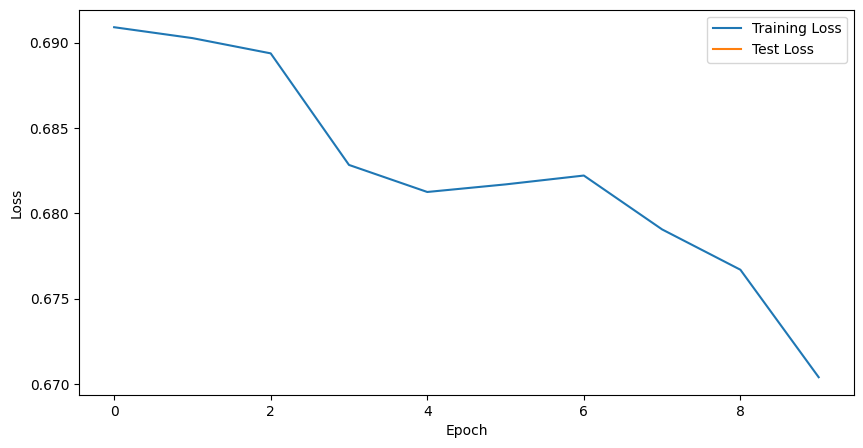

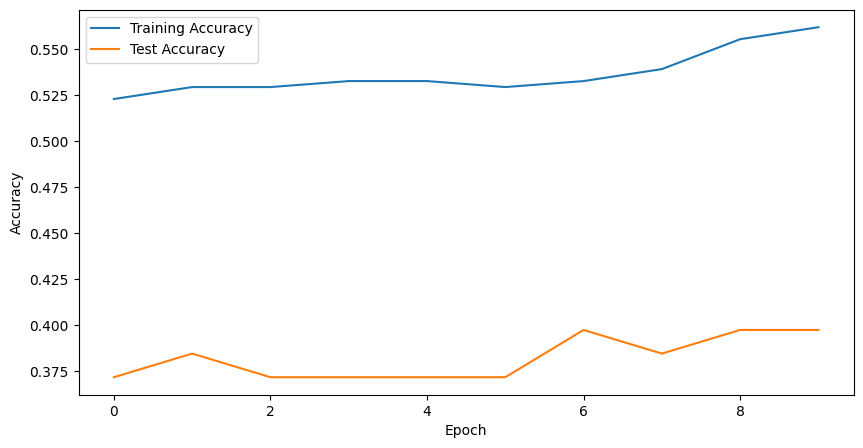

In [10]:
import matplotlib.pyplot as plt

# Eğitim ve test loss değerlerini ve doğruluk değerlerini grafiğe dökme
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()